# Introduction

In this notebook, a thourough exploratory data analysis is conducted on the dataset used for training the gpt-2 model for arabic quotes generation.

**Dataset size:** 500 000 quotes.

In [3]:
# Importing libraries for EDA

import numpy as np
import pandas as pd
from tqdm import tqdm

from bertopic import BERTopic
from flair.embeddings import TransformerDocumentEmbeddings
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from gensim.models import LdaMulticore
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
import seaborn as sb
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from PIL import Image
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display

sb.set(style="darkgrid")
%matplotlib inline

# Importing data & performing EDA


In [6]:
data= pd.read_csv('./complete_arabic_quotes.csv')
data.sample(5)

quote      tag
59640  كونها قيثارة يمكن لأقل رياح من المشاعر من قلب ...  العواطف
49032           سأضع الموت في كل طعامهم وأشاهدهم يموتون.     يكره
17887  Donde termina el arco iris، en tu alma o en el...      أمل
70581  للإجابة على سؤال "إلى أين أنا ذاهب؟" الانخراط ...    الحزم
4180   ما تكاد الروح تدركه هو أن وحدته ، سواء كانت غي...     الله

In [7]:
print(f'There are a total of {data.shape[0]} quote in this dataset')

There are a total of 90000 quote in this dataset


In [8]:
# Number of quote per tag

data.tag.value_counts().reset_index()

index   tag
0                    دعابة  2170
1                     ملهم  1940
2                       فن  1426
3                     الحب  1411
4                    الكتب  1381
...                    ...   ...
11628           دشان ستوكس     1
11629  سوزان باربرا أبولون     1
11630              التأخير     1
11631                 رجاء     1
11632    السيطرة على العقل     1

[11633 rows x 2 columns]

In [9]:
# function to reshape arabic text for correct display

def ar_reshape(text):
    return get_display( arabic_reshaper.reshape(text))

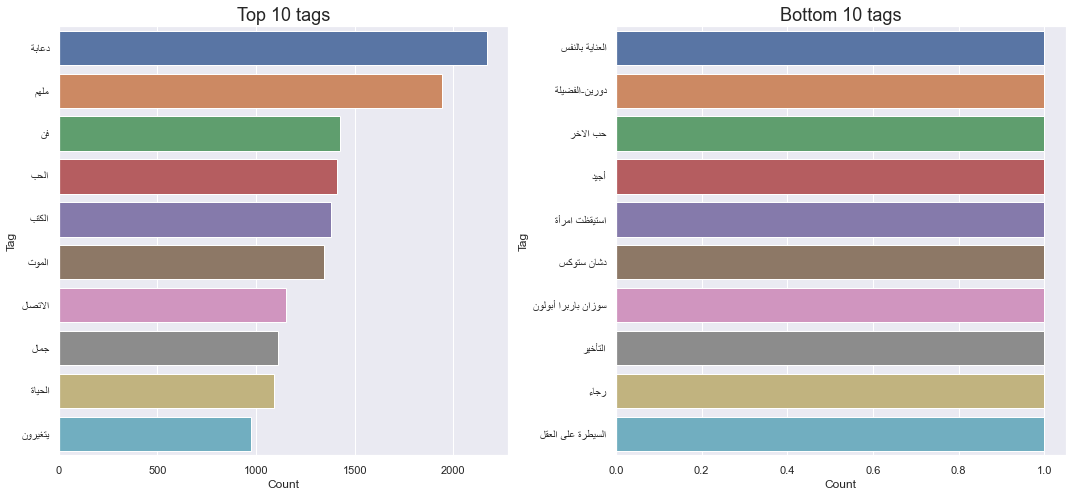

In [10]:
# display top & bottom 10 tags by number of quotes

fig, axs = plt.subplots(1,2, figsize=(15, 7))

sb.barplot(data.tag.value_counts().reset_index()[:10], x='tag', y='index', ax=axs[0])
l_tags = list(data.tag.value_counts().reset_index()[:10]['index'])
reshaped_l = list(map(ar_reshape, l_tags))
axs[0].set_yticks(np.arange(10),reshaped_l)
axs[0].set_ylabel('Tag')
axs[0].set_xlabel('Count')
axs[0].set_title('Top 10 tags', fontsize=18)

sb.barplot(data.tag.value_counts().reset_index()[-10:], x='tag', y='index', ax=axs[1])
l_tags = list(data.tag.value_counts().reset_index()[-10:]['index'])
reshaped_l = list(map(ar_reshape, l_tags))
axs[1].set_yticks(np.arange(10),reshaped_l)
axs[1].set_ylabel('Tag')
axs[1].set_xlabel('Count')
axs[1].set_title('Bottom 10 tags', fontsize=18)

plt.tight_layout();

In [11]:
# Creating 'length' feature

data['quote_length'] = data['quote'].str.len()
data.head()

quote           tag  \
0  يجب أن ترقص كما لو أنه لا يوجد أحد يشاهد ، أحب...         الرقص   
1  أنت تعلم أنك في حالة حب عندما لا تستطيع النوم ...  ينسب لا مصدر   
2  الصديق هو الشخص الذي يعرف كل شيء عنك ولا يزال ...          صديق   
3  لا يمكن للظلام أن يطرد الظلام: النور وحده قادر...        الظلام   
4                    نقبل الحب الذي نظن اننا نستحقه.          ملهم   

   quote_length  
0           130  
1            83  
2            51  
3           122  
4            31

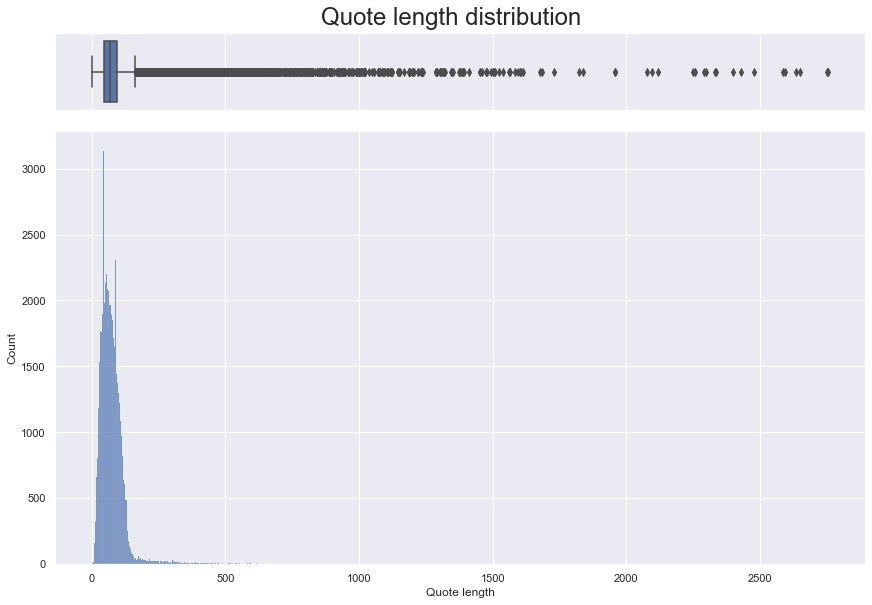

In [12]:
# creating a figure

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
f.set_figheight(8)
f.set_figwidth(12)
f.tight_layout()
f.suptitle('Quote length distribution', y=1.02, fontsize=24)

# assigning a graph to each axis

sb.boxplot(x=data["quote_length"], ax=ax_box, )
sb.histplot(data=data, x="quote_length", ax=ax_hist)
ax_hist.set_xlabel('Quote length')
ax_box.set_xlabel('')

plt.show()

In [13]:
# descriptive statistics of the quote length values distribution

data['quote_length'].describe()

count    90000.000000
mean        79.949344
std         84.902563
min          1.000000
25%         46.000000
50%         67.000000
75%         93.000000
max       2755.000000
Name: quote_length, dtype: float64

In [14]:
# Calculating the upper and lower whiskers of the boxplot displayed above

median = np.median(data['quote_length'])
upper_quartile = np.percentile(data['quote_length'], 75)
lower_quartile = np.percentile(data['quote_length'], 25)

iqr = upper_quartile - lower_quartile
upper_whisker = data.quote_length[data['quote_length']<=upper_quartile+1.5*iqr].max()
lower_whisker = data.quote_length[data['quote_length']>=lower_quartile-1.5*iqr].min()

print(f"The uppwer whisker value is: {upper_whisker}\nThe lower whisker value is: {lower_whisker}")

The uppwer whisker value is: 163
The lower whisker value is: 1


Based on the whiskers values, we will drop all the quotes that are longer than 163 character.

## Data Cleaning

In [15]:
max_length = 163
pd.options.display.max_colwidth = 163
data = data[data['quote_length']<max_length]
data.head()

quote  \
0  يجب أن ترقص كما لو أنه لا يوجد أحد يشاهد ، أحب كما لو أنك لن تتأذى أبدًا ، وغني كأن لا أحد يستمع ، وعيش كما لو كانت جنة على الأرض.   
1                                                 أنت تعلم أنك في حالة حب عندما لا تستطيع النوم لأن الواقع في النهاية أفضل من أحلامك.   
2                                                                                 الصديق هو الشخص الذي يعرف كل شيء عنك ولا يزال يحبك.   
3          لا يمكن للظلام أن يطرد الظلام: النور وحده قادر على فعل ذلك. لا يمكن للكراهية أن تطرد الكراهية: الحب وحده هو الذي يفعل ذلك.   
4                                                                                                     نقبل الحب الذي نظن اننا نستحقه.   

            tag  quote_length  
0         الرقص           130  
1  ينسب لا مصدر            83  
2          صديق            51  
3        الظلام           122  
4          ملهم            31

In [16]:
print(f'The remaining number of quotes in this dataset after cleaning is {data.shape[0]}.')

The remaining number of quotes in this dataset after cleaning is 86610.


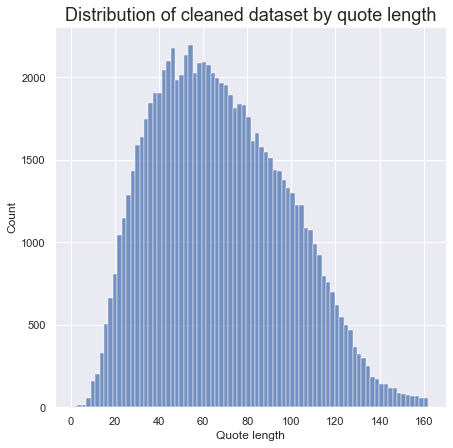

In [17]:
fig, ax = plt.subplots(figsize=(7, 7))
sb.histplot(data['quote_length'], ax=ax)
ax.set_xlabel('Quote length')
ax.set_title('Distribution of cleaned dataset by quote length', fontsize=18);

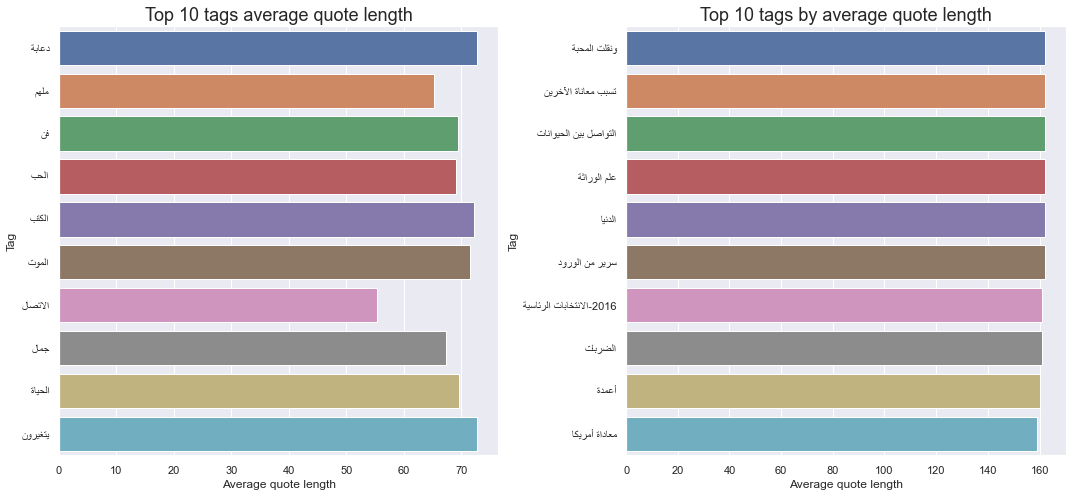

In [18]:
# display top & bottom 10 tags average quote length

fig, axs = plt.subplots(1,2,figsize=(15, 7))

sb.barplot(data[['tag','quote_length']].groupby(['tag']).mean().sort_values(by='quote_length', ascending=False).loc[data.tag.value_counts().index[:10]].reset_index(),
 x='quote_length', y='index', ax=axs[0])
l_tags = list(data.tag.value_counts().reset_index()[:10]['index'])
reshaped_l = list(map(ar_reshape, l_tags))
axs[0].set_yticks(np.arange(10),reshaped_l)
axs[0].set_ylabel('Tag')
axs[0].set_xlabel('Average quote length')
axs[0].set_title('Top 10 tags average quote length', fontsize=18)

sb.barplot(data[['tag','quote_length']].groupby(['tag']).mean().sort_values(by='quote_length', ascending=False)[:10].reset_index(), x='quote_length', y='tag', ax=axs[1])
l_tags = list(data[['tag','quote_length']].groupby(['tag']).mean().sort_values(by='quote_length', ascending=False)[:10].reset_index()['tag'])
reshaped_l = list(map(ar_reshape, l_tags))
axs[1].set_yticks(np.arange(10),reshaped_l)
axs[1].set_ylabel('Tag')
axs[1].set_xlabel('Average quote length')
axs[1].set_title('Top 10 tags by average quote length', fontsize=18)

plt.tight_layout();

## Topic Modelling

In this section, we're going to use a BERT model used for topic modelling called BERTopic. Using BERTopic we will define a number of clusters for the quote dataset.\
We will then explore the produced cluster and discuss the possibilities of using them to better understand the data and to clean it even further.
[BERTopic](https://maartengr.github.io/BERTopic/algorithm/algorithm.html)

In [4]:
# instantiate a BERTopic model with a custom bert model for Arabic embeddings

arabert = TransformerDocumentEmbeddings('aubmindlab/bert-base-arabertv02')
topic_model = BERTopic(language="arabic", low_memory=True ,calculate_probabilities=False, embedding_model=arabert)

In [19]:
# create a numpy array from the quotes column

documents = data['quote'].values

In [16]:
# train and fit the BERTopic model on the quotes data

topics, probs = topic_model.fit_transform(documents)

In [22]:
# load a BERTopic model if possible

topic_model= BERTopic.load('./BERTopic_model')

In [ ]:
topics, probs = topic_model.transform(documents)

In [21]:
#extract most frequent topics

topic_model.get_topic_freq().head(5)

Topic  Count
0      0  70407
1      1   7735
2      2   1817
3      3   1683
4     -1   1609

In [22]:
#show the top 10 words in topic 1

topic_model.get_topic(1)[:10]

[('لا', 0.024489305390315897),
 ('في', 0.020344325660685805),
 ('من', 0.02027088974186863),
 ('هو', 0.01903522327724294),
 ('الله', 0.018326240243457255),
 ('أن', 0.017874801151331724),
 ('على', 0.015406529144979024),
 ('إلى', 0.014701275838780371),
 ('ما', 0.014383811858926777),
 ('الحياة', 0.014042132391044338)]

In [23]:
topic_model.visualize_topics()

In [24]:
topic_model.visualize_documents(documents, sample=0.1)

In [43]:
# save the used BERTopic model

topic_model.save("BERTopic_model")

## Word cloud
In this section, we will use word clouds to explore the quotes dataset. Using this tachnique allows us to have a deeper look on the vocabulary used in the dataset.

In [99]:
# read the stop words file

stopwords = set(map(str.strip, open("./stopwords", encoding="utf8").readlines()))

In [100]:
# define a function that removes stopwords from a string

def remove_sw(text, stopwords):
    l = text.split(' ')
    for w in stopwords:
        l=list(filter((w).__ne__, l))
    text = ' '.join(l)
    return text

In [241]:
# define a function that retuns a wordcloud object given a "tag" and a "mask" image
def get_wordcloud(tag, mask_img):
    if tag=='':
        l=[]
        for quote in tqdm(data.quote.values):
            l.append(remove_sw(quote,stopwords))
        text = ' '.join(l)
    else:
        l=[]
        for quote in tqdm(data[data['tag']==tag].quote.values):
            l.append(remove_sw(quote,stopwords))
        text = ' '.join(l)

    text = arabic_reshaper.reshape(text)
    text = get_display(text)

    wordcloud = WordCloud(font_path='./NotoKufiArabic-Regular.ttf', width=800, height=400, mask=mask_img, background_color='white').generate(text)
    return wordcloud

100%|██████████| 1342/1342 [00:00<00:00, 5637.35it/s]


(-0.5, 839.5, 858.5, -0.5)

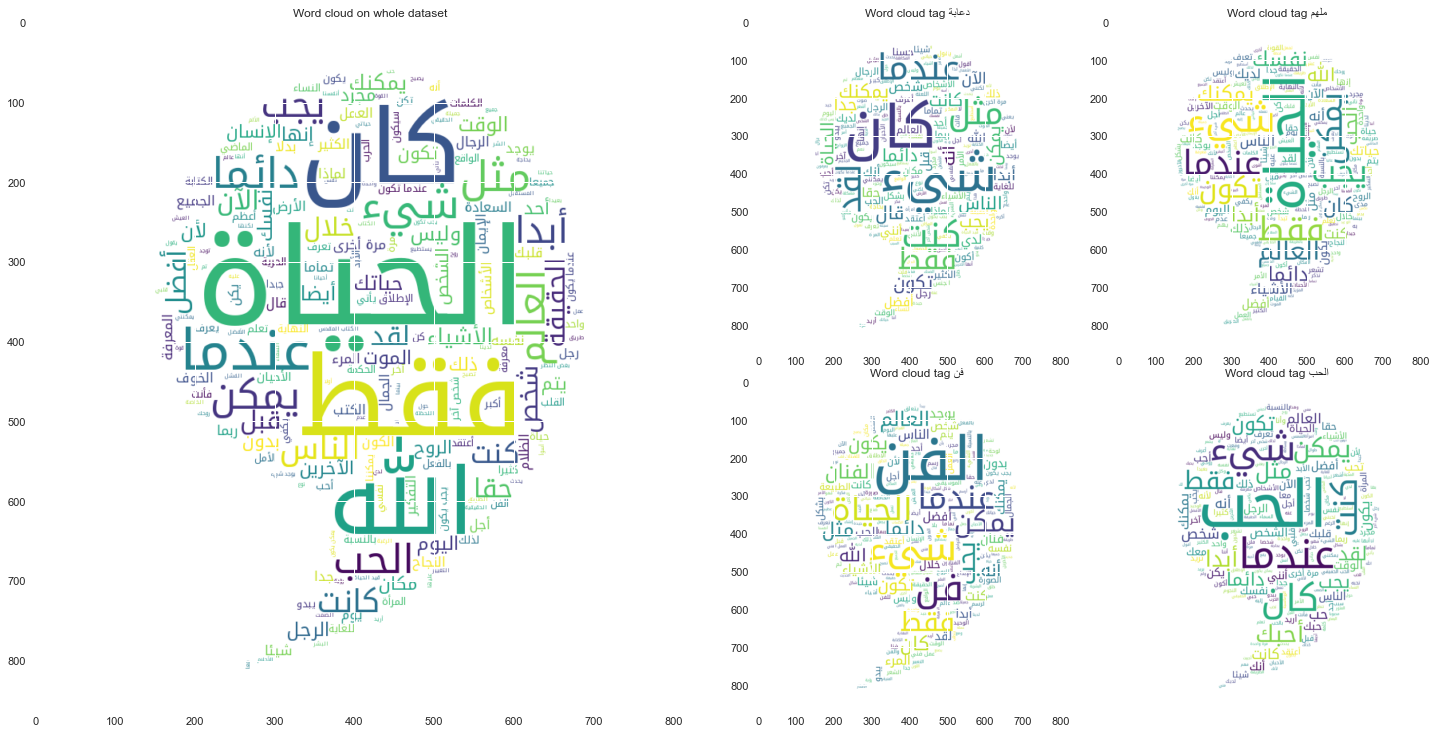

In [246]:
# create and display word clouds for the wholde dataset and for the top 5 tags.
mask_img = np.array(Image.open("./mask.png"))
wordcloud_data = get_wordcloud(tag='', mask_img=mask_img)
wordcloud_toptag1 = get_wordcloud(tag=data.tag.value_counts().index[0], mask_img=mask_img)
wordcloud_toptag2 = get_wordcloud(tag=data.tag.value_counts().index[1], mask_img=mask_img)
wordcloud_toptag3 = get_wordcloud(tag=data.tag.value_counts().index[2], mask_img=mask_img)
wordcloud_toptag4 = get_wordcloud(tag=data.tag.value_counts().index[3], mask_img=mask_img)
tag1 = get_display(arabic_reshaper.reshape('دعابة'))
tag2 = get_display(arabic_reshaper.reshape('ملهم'))
tag3 = get_display(arabic_reshaper.reshape('فن'))
tag4 = get_display(arabic_reshaper.reshape('الحب'))

plt.figure(figsize=(20,10))
ax1 = plt.subplot(121)
ax1.imshow(wordcloud_data, interpolation='bilinear')
ax1.set_title('Word cloud on whole dataset')
ax2 = plt.subplot(243)
ax2.imshow(wordcloud_toptag1, interpolation='bilinear')
ax2.set_title(f'Word cloud tag {tag1}')
ax3 = plt.subplot(244)
ax3.imshow(wordcloud_toptag2, interpolation='bilinear')
ax3.set_title(f'Word cloud tag {tag2}')
ax4 = plt.subplot(247)
ax4.imshow(wordcloud_toptag3, interpolation='bilinear')
ax4.set_title(f'Word cloud tag {tag3}')
ax5 = plt.subplot(248)
ax5.imshow(wordcloud_toptag4, interpolation='bilinear')
ax5.set_title(f'Word cloud tag {tag4}')
plt.tight_layout(pad=0)
plt.axis("off")

## Sentiment analysis
Performing sentiment analysis on this dataset is a very powerful method to investigate the general sentiment on of dataset as a whole. Moreover, we can use to automatically extract the negative quotes that shouldn't be present in our dataset and remove them.

In [247]:
# create a sentiment analysis pipeline using a pretrained Arabic BERT model

from transformers import pipeline
sa = pipeline('text-classification', model='CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment')


# perform sentiment analysis on the dataset

res = sa(list(data.quote))

Downloading:   0%|          | 0.00/841 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/297k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

[{'label': 'positive', 'score': 0.8008126616477966},
 {'label': 'negative', 'score': 0.6131933927536011}]

In [254]:
# convert the result to a pandas dataframe and save it to a csv file

sa_results = pd.DataFrame(res)
sa_results.to_csv('sa_results.csv', index=False)

In [15]:
# read the sentiment analysis from a csv file if possible

sa_results = pd.read_csv('./sa_results.csv')

In [16]:
# merging the quotes dataset with the sentiment analysis results

data = pd.merge(left=data, right=sa_results, left_index=True, right_index=True)
data

quote  \
0      يجب أن ترقص كما لو أنه لا يوجد أحد يشاهد ، أحب كما لو أنك لن تتأذى أبدًا ، وغني كأن لا أحد يستمع ، وعيش كما لو كانت جنة على الأرض.   
1                                                     أنت تعلم أنك في حالة حب عندما لا تستطيع النوم لأن الواقع في النهاية أفضل من أحلامك.   
2                                                                                     الصديق هو الشخص الذي يعرف كل شيء عنك ولا يزال يحبك.   
3              لا يمكن للظلام أن يطرد الظلام: النور وحده قادر على فعل ذلك. لا يمكن للكراهية أن تطرد الكراهية: الحب وحده هو الذي يفعل ذلك.   
4                                                                                                         نقبل الحب الذي نظن اننا نستحقه.   
...                                                                                                                                   ...   
86201                                               سواء اخترت المسار الأيسر أو الأيمن ، ولكن يجب أن تتمتع الوجهة برضا الروح "- سمر سودها   
86202                                                                                                لا تضيع الدموع. إنها أعمق روح مهدئة.   
86203                                                                    إن قلب ما أنت عليه ليس جسدك أو أفكارك ، بل هو الوعي الصافي نفسه.   
86204                                                                                     عندما تشفي الروح تختفي مشاكل الجسد كما لم تحدث.   
86205                           عندما تنوم تنهدات الحزن لحظات سعيدة تحتاج إلى استعارة من طفل صغير أو من طائر له حرية الروح البرية: إثارة!   

                tag  quote_length     label     score  
0             الرقص           130  positive  0.864416  
1      ينسب لا مصدر            83  positive  0.742602  
2              صديق            51  positive  0.834845  
3            الظلام           122  positive  0.972091  
4              ملهم            31  positive  0.490092  
...             ...           ...       ...       ...  
86201       القناعة            85   neutral  0.627947  
86202          بكاء            36  negative  0.628824  
86203        الصحوة            64   neutral  0.495175  
86204          هيئة            47  positive  0.931659  
86205         عصفور           105   neutral  0.465256  

[82931 rows x 5 columns]

In [38]:
fig = px.histogram(data, x='score', color='label', color_discrete_sequence=["green", "goldenrod","red"], title="Confidence score distribution per sentiment")
fig.show()

In [39]:
fig = px.pie(data, names='label',  color_discrete_sequence=["green", "goldenrod","red"], title="Quotes sentiment")
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [18]:
# display the top 5 tags in each sentiment gategory
df_pos = data[data.label=='positive'].tag.value_counts().reset_index().sort_values('tag', ascending=False)[:5]
df_pos['label']='positive'

df_neu = data[data.label=='neutral'].tag.value_counts().reset_index().sort_values('tag', ascending=False)[:5]
df_neu['label']='neutral'

df_neg = data[data.label=='negative'].tag.value_counts().reset_index().sort_values('tag', ascending=False)[:5]
df_neg['label']='negative'

df = pd.concat([df_pos, df_neu, df_neg], ignore_index=True)

px.sunburst(df, path=['label','index'], values='tag',  color_discrete_sequence=["green", "goldenrod","red"])

**To be continued..**